In [1]:
# Se importan las librerías necesarias
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

In [ ]:
# 1) Datos transcritos - Álvaro
non_scam_texts_alvaro = pd.read_csv("metadata_alvaro_normal.csv", sep='|', header=None)
scam_texts_alvaro = pd.read_csv("metadata_alvaro_scam.csv", sep='|', header=None)

non_scam_texts = non_scam_texts_alvaro[1].values.tolist()
scam_texts = scam_texts_alvaro[1].values.tolist()

# JuanFran
non_scam_texts_juanfran = pd.read_csv("metadata_juanfran_normal.csv", sep='|', header=None)
scam_texts_juanfran = pd.read_csv("metadata_juanfran_scam.csv", sep='|', header=None)

non_scam_texts.extend(non_scam_texts_juanfran[1].values.tolist())
scam_texts.extend(scam_texts_juanfran[1].values.tolist())

# Pablo
non_scam_texts_pablo = pd.read_csv("metadata_pablo_normal.csv", sep='|', header=None)
scam_texts_pablo = pd.read_csv("metadata_pablo_scam.csv", sep='|', header=None)

non_scam_texts.extend(non_scam_texts_pablo[1].values.tolist())
scam_texts.extend(scam_texts_pablo[1].values.tolist())

# Sergio
non_scam_texts_sergio = pd.read_csv("metadata_sergio_normal.csv", sep='|', header=None)
scam_texts_sergio = pd.read_csv("metadata_sergio_scam.csv", sep='|', header=None)

non_scam_texts.extend(non_scam_texts_sergio[1].values.tolist())
scam_texts.extend(scam_texts_sergio[1].values.tolist())

# Pilar
non_scam_texts_pilar = pd.read_csv("metadata_pilar_normal.csv", sep='|', header=None)
scam_texts_pilar = pd.read_csv("metadata_pilar_scam.csv", sep='|', header=None)

non_scam_texts.extend(non_scam_texts_pilar[1].values.tolist())
scam_texts.extend(scam_texts_pilar[1].values.tolist())

In [2]:
# 2) Modelo de embeddings (multilingüe, rápido y sólido)
model = SentenceTransformer("intfloat/multilingual-e5-base")  # alternativa: "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

# Es recomienda anteponer "query: " o "passage: ", pero para un clasificador simple podemos usar texto crudo
emb_scam = model.encode(scam_texts, normalize_embeddings=True)
emb_non  = model.encode(non_scam_texts, normalize_embeddings=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

NameError: name 'scam_texts' is not defined

In [7]:
# 3) Centroides por clase
centroid_scam = emb_scam.mean(axis=0, keepdims=True)   # shape (1, d)
centroid_non  = emb_non.mean(axis=0, keepdims=True)    # shape (1, d)

def predict_label(texts):
    """
    Esta función predice si un conjunto de textos corresponde a "scam" (fraude) o "non-scam"
    (no fraude) utilizando la similitud de coseno con los centroides predefinidos para cada categoría.

    Argumentos:
    texts (list or array): Lista de textos a clasificar. Cada texto será evaluado
                          en cuanto a su similitud con los centroides "scam" y "non-scam".

    Retorna:
    - preds (array): Un arreglo de predicciones donde cada valor es 1 si el texto se clasifica
                    como "scam" y 0 si se clasifica como "non-scam".
    - sim_scam (array): Un arreglo con los valores de similitud de coseno entre cada texto y
                        el centroide de "scam".
    - sim_non (array): Un arreglo con los valores de similitud de coseno entre cada texto y
                        el centroide de "non-scam".
    - margin (array): Un arreglo que muestra la diferencia entre las similitudes de "scam" y
                      "non-scam", que puede servir para ver cuán "convincente" es la predicción.

    El proceso consiste en calcular las similitudes de coseno de los textos con los centroides
    predefinidos para las dos categorías (scam y non-scam), luego se asigna la etiqueta 1 (scam)
    si la similitud con el centroide de "scam" es mayor que la similitud con el centroide de
    "non-scam", o 0 (non-scam) en caso contrario. También se calcula un "margen" que muestra
    la diferencia de similitudes para evaluar la confianza de la predicción.

    """
    emb = model.encode(texts, normalize_embeddings=True)
    sim_scam = cosine_similarity(emb, centroid_scam).ravel()
    sim_non  = cosine_similarity(emb, centroid_non).ravel()
    preds = (sim_scam > sim_non).astype(int)  # 1=scam si está más cerca del centroide scam
    margin = sim_scam - sim_non              # utilidad: qué tan “convencido” está
    return preds, sim_scam, sim_non, margin

In [11]:
# Guardar centroides en un csv
centroid_non_df = pd.DataFrame(centroid_non)
centroid_non_df.to_csv("centroid_non.csv", index=False)

centroid_scam_df = pd.DataFrame(centroid_scam)
centroid_scam_df.to_csv("centroid_scam.csv", index=False)

NameError: name 'centroid_non' is not defined

In [12]:
# Cargar centroide y guardarlo en una variable como array
centroid_non_df = pd.read_csv("centroid_non.csv")
centroid_non = centroid_non_df.to_numpy()

centroid_scam_df = pd.read_csv("centroid_scam.csv")
centroid_scam = centroid_scam_df.to_numpy()

In [ ]:
# 4) Ejemplo de inferencia
nuevos = [
    "Su cuenta ha sido temporalmente suspendida. Verifique sus datos aquí.",
    "¿Comemos mañana sobre las 14:00 cerca de la oficina?",
    "Su cuenta bancaria ha sido bloqueada por actividad sospechosa. Inicie sesión aquí para verificar sus datos.",
    "Ha ganado la lotería internacional. Reclame su premio enviando su número de tarjeta de crédito.",
    "Estimado usuario, hemos detectado un problema en su cuenta de PayPal. Por favor, confirme su contraseña inmediatamente.",
    "Último aviso: su paquete no pudo ser entregado. Haga clic en este enlace para pagar los gastos de envío.",
    "Hemos seleccionado su perfil para un reembolso especial. Complete el formulario con su información personal.",
    "Hola Juan, ¿puedes confirmar si vienes a la reunión mañana a las 10?",
    "Recordatorio: tu cita médica está programada para el martes a las 15:30.",
    "Gracias por tu compra. Tu pedido será enviado en un plazo de 3 a 5 días.",
    "Feliz cumpleaños, esperamos que disfrutes mucho tu día con tus seres queridos.",
    "El informe mensual ya está listo, te lo enviaré por correo en cuanto lo revise.",
    "Su cuenta bancaria ha sido bloqueada por accesos inusuales. Verifique su identidad en el siguiente enlace en los próximos 15 minutos.",
    "Hacienda le debe un reembolso. Para recibirlo hoy, complete su información bancaria aquí.",
    "Su Apple ID caducará. Confirme su contraseña y código de verificación ahora.",
    "Paquete retenido por aranceles. Pague 1,99€ para liberar la entrega.",
    "Ha sido seleccionado para una inversión garantizada del 30% semanal. Envíe USDT a la siguiente dirección.",
    "Último aviso: su suscripción será cancelada hoy. Renueve introduciendo su tarjeta para evitar cargos.",
    "Detectamos malware en su ordenador. Llame al soporte técnico y permita acceso remoto para solucionarlo.",
    "Su cuenta de PayPal está limitada. Inicie sesión para resolver un cargo no autorizado.",
    "Ganador del sorteo europeo. Para cobrar, proporcione su IBAN y una copia de su DNI.",
    "Se ha iniciado sesión desde un dispositivo desconocido. Si no fue usted, verifique sus datos aquí.",
    "¿Puedes revisar el informe de ventas y mandarme tus comentarios antes del viernes?",
    "Te adjunto la presentación actualizada para la reunión de mañana.",
    "El pedido #4821 ha sido enviado. Recibirás otro correo cuando esté en reparto.",
    "Gracias por tu ayuda ayer con el despliegue, salió todo perfecto.",
    "Recordatorio: clase de yoga a las 19:00 en el centro cívico.",
    "Confirmo la reserva para dos personas el sábado a las 21:30.",
    "El equipo de soporte cerró el ticket; avísanos si el problema vuelve.",
    "Esta semana trabajo remoto miércoles y jueves, por si necesitas algo.",
    "Felicitaciones por el proyecto, la demo quedó muy clara.",
    "¿Te viene bien que hagamos la llamada a las 16:00?"
]
preds, s_scam, s_non, margin = predict_label(nuevos)
for t, y, ms, mn, m in zip(nuevos, preds, s_scam, s_non, margin):
    print(f"- Texto: {t}\n  Pred: {y} (1=scam) | sim_scam={ms:.3f} sim_non={mn:.3f} | margen={m:.3f}\n")

- Texto: Su cuenta ha sido temporalmente suspendida. Verifique sus datos aquí.
  Pred: 1 (1=scam) | sim_scam=0.926 sim_non=0.904 | margen=0.022

- Texto: ¿Comemos mañana sobre las 14:00 cerca de la oficina?
  Pred: 0 (1=scam) | sim_scam=0.863 sim_non=0.898 | margen=-0.035

- Texto: Su cuenta bancaria ha sido bloqueada por actividad sospechosa. Inicie sesión aquí para verificar sus datos.
  Pred: 1 (1=scam) | sim_scam=0.941 sim_non=0.914 | margen=0.026

- Texto: Ha ganado la lotería internacional. Reclame su premio enviando su número de tarjeta de crédito.
  Pred: 1 (1=scam) | sim_scam=0.911 sim_non=0.888 | margen=0.023

- Texto: Estimado usuario, hemos detectado un problema en su cuenta de PayPal. Por favor, confirme su contraseña inmediatamente.
  Pred: 1 (1=scam) | sim_scam=0.935 sim_non=0.919 | margen=0.016

- Texto: Último aviso: su paquete no pudo ser entregado. Haga clic en este enlace para pagar los gastos de envío.
  Pred: 1 (1=scam) | sim_scam=0.927 sim_non=0.916 | margen=0.01

In [9]:
# 5) Inferencia - Matriz de confusión
# Generar lista con textos normales
normal_texts_data = [
        "Hola, ¿cómo estás? Quería ver si podemos reunirnos mañana.",
        "El informe mensual ya está listo, te lo enviaré por correo en cuanto lo revise.",
        "Recordatorio: tu cita médica está programada para el martes a las 15:30.",
        "Gracias por tu compra. Tu pedido será enviado en un plazo de 3 a 5 días.",
        "Feliz cumpleaños, esperamos que disfrutes mucho tu día con tus seres queridos.",
        "¿Puedes revisar el informe de ventas y mandarme tus comentarios antes del viernes?",
        "Te adjunto la presentación actualizada para la reunión de mañana.",
        "El pedido #4821 ha sido enviado. Recibirás otro correo cuando esté en reparto.",
        "Gracias por tu ayuda ayer con el despliegue, salió todo perfecto.",
        "Recordatorio: clase de yoga a las 19:00 en el centro cívico.",
        "Confirmo la reserva para dos personas el sábado a las 21:30.",
        "El equipo de soporte cerró el ticket; avísanos si el problema vuelve.",
        "Esta semana trabajo remoto miércoles y jueves, por si necesitas algo.",
        "Felicitaciones por el proyecto, la demo quedó muy clara.",
        "¿Te viene bien que hagamos la llamada a las 16:00?",
        "¿Vamos al cine este fin de semana? Hay una película interesante.",
        "No olvides comprar leche y pan al volver a casa.",
        "La reunión ha sido pospuesta para el lunes a las 11.",
        "He terminado la tarea, ¿quieres que te la envíe para que la revises?",
        "Estoy en el supermercado, ¿necesitas algo antes de que vuelva?",
        "El concierto de esta noche empieza a las 20:00.",
        "Recuerda que tenemos cena con los García el sábado.",
        "He recibido el paquete que esperaba, ¡gracias!",
        "¿Podrías regar las plantas mientras estoy de viaje?",
        "El gimnasio cierra a las 22:00 hoy.",
        "He encontrado un artículo interesante sobre nuestro proyecto.",
        "¿Quedamos para tomar un café después del trabajo?",
        "El autobús llega en 5 minutos, ya estoy en la parada.",
        "La batería de mi teléfono se está agotando, te llamo luego.",
        "He enviado el documento por email, por favor confírmame que lo recibiste.",
        "Mañana hay huelga de transporte, mejor sal con tiempo.",
        "He preparado la comida, ¿ya vienes?",
        "La alarma no ha sonado, creo que llegaré tarde.",
        "He comprado las entradas para el partido.",
        "El coche está en el taller, me lo entregan mañana.",
        "Estoy atascado en el tráfico, llego un poco más tarde.",
        "La presentación es a las 9 de la mañana.",
        "He estado buscando tu libro pero no lo encuentro.",
        "El frigorífico hace un ruido raro, ¿lo has oído?",
        "He reservado las vacaciones para agosto.",
        "La temperatura va a bajar mañana, abrígate bien.",
        "He perdido las llaves, ¿tienes una copia?",
        "La impresora no funciona, ¿sabes arreglarla?",
        "He recibido una notificación del banco, parece importante.",
        "El ascensor está roto, tendremos que subir por las escaleras.",
        "He estado aprendiendo a cocinar paella, ¿quieres probarla?",
        "El perro necesita ir al veterinario la próxima semana.",
        "He comprado un regalo para Ana, espero que le guste.",
        "La calle principal está cortada por obras.",
        "He empezado un curso online, está muy interesante.",
        "Necesito comprar un cargador nuevo para mi portátil.",
        "He visto la película que me recomendaste, me gustó mucho.",
        "El fin de semana pasado fui a la montaña, fue genial.",
        "He estado pensando en cambiar de trabajo.",
        "El ordenador va muy lento, creo que tiene un virus.",
        "He plantado unas flores en el jardín.",
        "El vecino puso música alta hasta tarde anoche.",
        "He leído un libro muy bueno, te lo recomiendo.",
        "El examen es la próxima semana, necesito estudiar más.",
        "He estado organizando mi armario, ¡qué desorden!",
    ]

# Generar lista con textos de estafa
scam_texts_data = [
        "Su cuenta ha sido temporalmente suspendida. Verifique sus datos aquí.",
        "Su cuenta bancaria ha sido bloqueada por actividad sospechosa. Inicie sesión aquí para verificar sus datos.",
        "Ha ganado la lotería internacional. Reclame su premio enviando su número de tarjeta de crédito.",
        "Estimado usuario, hemos detectado un problema en su cuenta de PayPal. Por favor, confirme su contraseña inmediatamente.",
        "Último aviso: su paquete no pudo ser entregado. Haga clic en este enlace para pagar los gastos de envío.",
        "Hemos seleccionado su perfil para un reembolso especial. Complete el formulario con su información personal.",
        "Su cuenta bancaria ha sido bloqueada por accesos inusuales. Verifique su identidad en el siguiente enlace en los próximos 15 minutos.",
        "Hacienda le debe un reembolso. Para recibirlo hoy, complete su información bancaria aquí.",
        "Su Apple ID caducará. Confirme su contraseña y código de verificación ahora.",
        "Paquete retenido por aranceles. Pague 1,99€ para liberar la entrega.",
        "Ha sido seleccionado para una inversión garantizada del 30% semanal. Envíe USDT a la siguiente dirección.",
        "Último aviso: su suscripción será cancelada hoy. Renueve introduciendo su tarjeta para evitar cargos.",
        "Detectamos malware en su ordenador. Llame al soporte técnico y permita acceso remoto para solucionarlo.",
        "Su cuenta de PayPal está limitada. Inicie sesión para resolver un cargo no autorizado.",
        "Ganador del sorteo europeo. Para cobrar, proporcione su IBAN y una copia de su DNI.",
        "Se ha iniciado sesión desde un dispositivo desconocido. Si no fue usted, verifique sus datos aquí.",
        "Soy agente de soporte de Amazon. Hemos detectado actividad sospechosa en su cuenta. Haga clic aquí.",
        "Su seguro médico está a punto de expirar. Si no renueva hoy, perderá la cobertura. Llame ahora.",
        "La policía cibernética detectó actividad ilegal en su IP. Para evitar arresto, pague una multa.",
        "Ha recibido un paquete retenido en aduanas. Para recibirlo, pague las tarifas en este enlace.",
        "Somos de Paypal. Su cuenta fue bloqueada por actividad inusual. Desbloquéela aquí.",
        "Usted debe renovar urgentemente la licencia de su software antivirus. Haga clic para actualizar.",
        "Hemos detectado que su cuenta bancaria fue duplicada. Necesitamos sus datos para confirmarla.",
        "tiene un proceso judicial abierto por deudas. Contacte a este número para resolverlo.",
        "Hola, soy del Banco Central. Por auditoría necesitamos que confirme sus datos por teléfono.",
        "Recibió una herencia millonaria. Para transferirla a su cuenta, pague una pequeña comisión.",
        "Buenas tardes, le hablo de su banco. Hemos detectado un intento de fraude. Confirme sus datos.",
        "Detectamos compras en línea del de otro país con su tarjeta. Confirme si fueron usted.",
        "Estimado cliente, su tarjeta será suspendida en 24 horas si no verifica su identidad.",
        "Hola, soy de soporte técnico. Su ordenador tiene virus. Permita acceso remoto para limpiarlo.",
        "Ganó un premio exclusivo de 10.000 euros. Para reclamarlo, envíe sus datos bancarios.",
        "Somos de la compañía telefónica. Tiene facturas pendientes. Pague aquí para evitar corte.",
        "Hemos detectado intentos de hackeo en su cuenta de correo. Cambie su contraseña aquí.",
        "Usted ha sido seleccionado en un sorteo internacional de coches. Reclame su premio aquí.",
        "Su cuenta de WhatsApp será desactivada. Para conservarla, haga clic en este enlace.",
        "Este es un aviso urgente. La autoridad fiscal requiere sus datos para un reembolso.",
        "Llamamos del Ministerio de Sanidad. Necesitamos actualizar sus datos médicos urgentes.",
        "Hola, su cuenta de WhatsApp ha sido comprometida. Ingrese sus datos para recuperarla.",
        "Le contactamos desde el Servicio de Atención al Cliente. Hay un problema con su pedido.",
        "Buenos días, su factura de la luz tiene un cobro indebido. Haga clic para reclamar.",
        "Le llamamos desde la agencia tributaria. Tiene una deuda pendiente. Pague aquí.",
        "Hola, soy del Seguro del Hogar. Se ha abierto un siniestro a su nombre. Confirme datos.",
        "Disculpe, su certificado digital ha caducado. Renúévelo en el siguiente enlace.",
        "Buenos días, ha sido seleccionado para un cheque regalo de 500 euros. Reclámelo aquí.",
        "Hola, estamos validando su acceso a la banca online. Ingrese su usuario y contraseña.",
        "Hola, soy de la entidad bancaria. Hemos detectado una transacción sospechosa. Confírmela.",
        "Buenos días, su paquete ha sido retenido por falta de dirección. Confirme sus datos de envío.",
        "Disculpe, llamamos del Sistema Nacional de Salud. Necesitamos verificar su información médica.",
        "Hola, le llamamos del servicio de pagos. Hay un problema con su último pago. Resuélvalo aquí.",
        "Llamamos de soporte técnico. Su cuenta de correo ha sido hackeada. Cambie su contraseña.",
        "Hola, soy del Ministerio. Estamos actualizando la base de datos. Necesitamos sus datos.",
        "Buenas, su acceso a la Seguridad Social ha sido suspendido. Verifíquelo con este enlace.",
        "Llamamos del área de protección de datos. Necesitamos verificar su identidad urgentemente.",
        "Su identidad ha sido comprometida. Siga las instrucciones para protegerse.",
        "Llamamos de la central antifraude. Para proteger su cuenta, necesitamos sus datos.",
        "Hola, le hablamos del servicio de atención al consumidor. Hay una reclamación a su nombre.",
        "Su cuenta de correo ha sido utilizada para enviar spam. Verifique su identidad.",
        "Una compra no autorizada ha sido realizada con su tarjeta. Confirme si la realizó usted.",
        "Está a punto de perder el acceso a su monedero virtual. Actualice su información.",
        "Su licencia de software ha caducado. Para renovarla, haga clic aquí.",
    ]

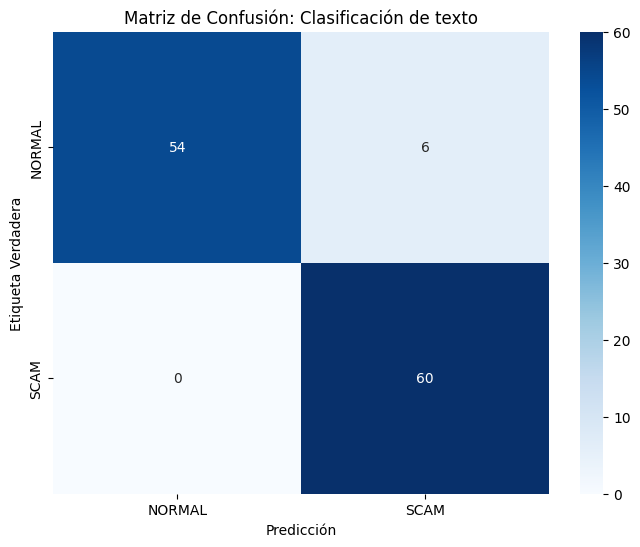

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Genera las etiquetas reales para los textos de ejemplo
true_labels = [0] * len(normal_texts_data) + [1] * len(scam_texts_data)
all_texts = normal_texts_data + scam_texts_data

# Obtiene las predicciones
preds, _, _, _ = predict_label(all_texts)

# Genera la matriz de confusión
cm = confusion_matrix(true_labels, preds)

# Muestra los resultados
id2label = {0: "NORMAL", 1: "SCAM"}
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión: Clasificación de texto')
plt.show()